<a href="https://colab.research.google.com/github/deClot/Hakaton_Superhero/blob/master/3_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [290]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from plotly.offline import init_notebook_mode, iplot

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

import IPython

def display(*dfs):
    for df in dfs:
        IPython.display.display(df)
 
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)


In [291]:
df = pd.read_excel('3_train.xlsx')
df.shape

(8501, 24)

In [292]:
df.rename(columns={'ConfirmedMonthlyIncome (Target)': 'target'}, inplace=True)

In [293]:
pd.concat([df.dtypes, df.nunique()], axis=1).rename(columns={0:'dtype', 1:'nunique'})

dtype  nunique
NaturalPersonID                                     object     8501
RequestDate                                 datetime64[ns]      584
ProductName                                         object        2
CreditSum                                          float64     2853
TypeOfWork                                          object        4
Employment                                          object        6
SignIP                                              object        1
sex                                                 object        2
age                                                  int64       45
EducationStatus                                     object        7
otrasl_rabotodatelya                                object       32
kolichestvo_rabotnikov_v_organizacii                object        4
Employment.1                                        object        6
OrgStanding_N                                      float64      388
kolichestvo_detej_mladshe_18                         int64        7
LivingRegionName                                    object       46
Residence                                           object        2
IncomeDocumentKind                                  object        5
HaveSalaryCard                                      object        2
IsBankWorker                                        object        2
TypeOfWork.1                                        object        4
SignIP.1                                            object        1
harakteristika_tekutschego_trudoustrojstva          object        2
target                                             float64     8104

In [294]:
df.drop('NaturalPersonID', axis=1, inplace=True)

In [295]:
df.kolichestvo_detej_mladshe_18 = df.kolichestvo_detej_mladshe_18.astype('object')

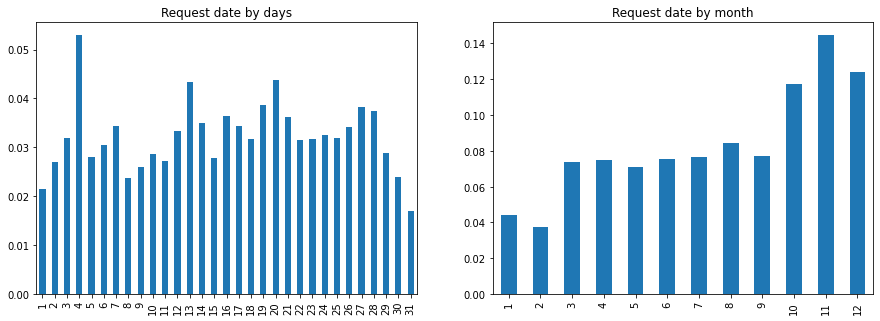

In [296]:
plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
temp = pd.DatetimeIndex(df.RequestDate).normalize().day
(temp.value_counts().sort_index().reindex(range(1,32))/temp.shape[0]).plot(kind='bar')
ax.set_title('Request date by days')

ax = plt.subplot(1,2,2)
temp = pd.DatetimeIndex(df.RequestDate).normalize().month
(temp.value_counts().sort_index().reindex(range(1,13))/temp.shape[0]).plot(kind='bar')
ax.set_title('Request date by month');

In [297]:
def get_season(x):
  return 1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4

def preprocess_datetime(df, time_columns):
    for t in time_columns:
        df[t+'_month'] = df[t].dt.month
        df[t+'_season'] = df[t+'_month'].apply(get_season)
        df[t+'_is_month_start'] = df[t].dt.is_month_start
        df[t+'_is_month_end'] = df[t].dt.is_month_end
        df[t+'_day'] = df[t].dt.day
        # df[t+'_hour'] = df[t].dt.hour
        df[t+'_dayofweek'] = df[t].dt.dayofweek
        df[t+'_is_weekend'] = df[t+'_dayofweek'] >= 5
        df[t+'_quarter'] = df[t].dt.quarter

In [298]:
preprocess_datetime(df, ['RequestDate'])
df = df.drop('RequestDate', axis=1)
features_time = [f for f in df.columns if 'RequestDate_' in f]
features_time

['RequestDate_month',
 'RequestDate_season',
 'RequestDate_is_month_start',
 'RequestDate_is_month_end',
 'RequestDate_day',
 'RequestDate_dayofweek',
 'RequestDate_is_weekend',
 'RequestDate_quarter']

In [299]:
features_cat =  df.select_dtypes('object').columns.tolist()
features_num = [f for f in df.columns if f not  in features_cat and f not in features_time]

assert len(features_num) + len(features_cat) + len(features_time) == df.shape[1]

# Pair plots
## Численные признаки

In [30]:
import seaborn as sns

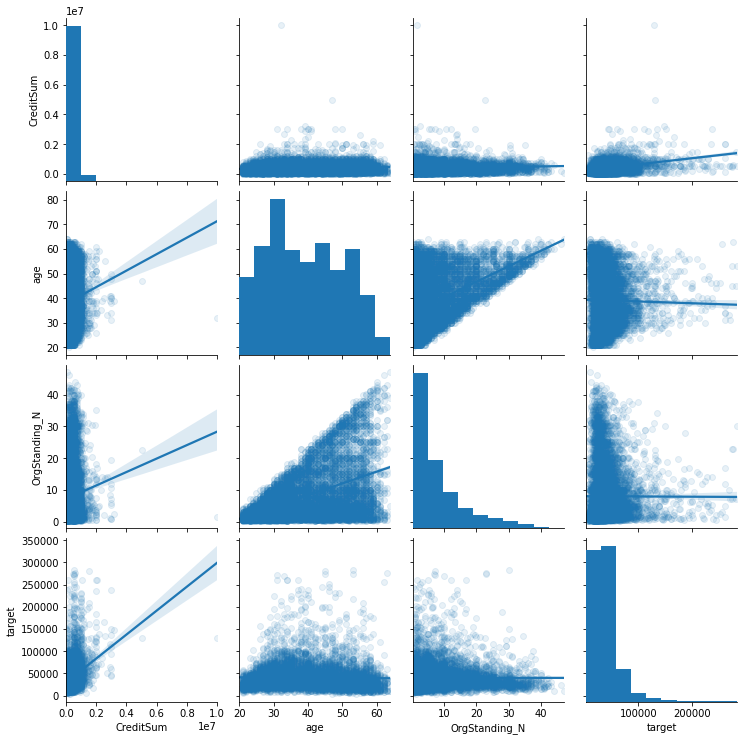

In [104]:
sns.pairplot(df[features_num], kind='reg', plot_kws={'scatter_kws':{'alpha': 0.1}});

10.0

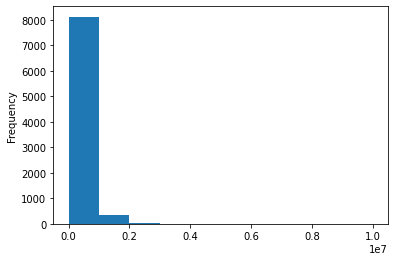

In [51]:
df.CreditSum.plot(kind='hist')
df.CreditSum.max()/10**6

In [54]:
df[df.CreditSum > 0.33*10**7][['CreditSum', 'ProductName', 'Employment', 'target']]

CreditSum  ...    target
906    5000000.0  ...  130500.0
6293  10000000.0  ...  129027.0

[2 rows x 4 columns]

Считать выбросами запросы на сумму 5 и 10 млн руб?

In [69]:
plt.rcParams['figure.figsize'] = [10,5]

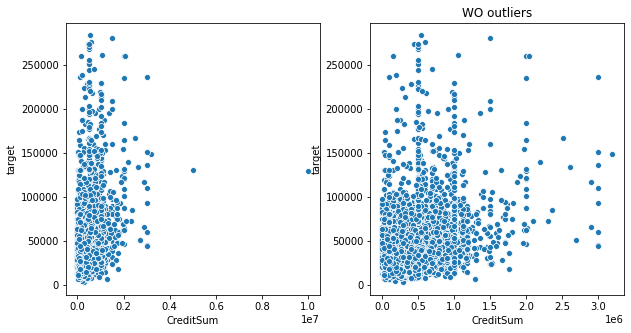

In [74]:
ax = plt.subplot(121)
sns.scatterplot(y='target', x='CreditSum', data=df)

ax = plt.subplot(122)
sns.scatterplot(y='target', x='CreditSum', data=df[df.CreditSum <= 0.35*10**7])
ax.set_title('WO outliers');

In [81]:
def plot_features_hist(features, target, df, drop_val=None):
    n = len(features)    
    fig = make_subplots(rows=int(np.ceil(n/4)), cols=4,
                       subplot_titles=features)
                        #[str(i) for i in range(len(features))])
    for i, f in enumerate(features):
        row, col = i//4+1, i%4+1
        showlegend = True if i == 0 else False
        color = '#636EFA'
        # for unique,color in zip(df[target].unique(), ['#636EFA', '#EF553B']):
        fig.add_trace(go.Histogram(x=df.loc[(df[f]!=drop_val), f], 
                                       histnorm='percent', marker_color=color, showlegend=showlegend), 
                           row=row, col=col)
    fig.update_layout(height=(2*np.ceil(n/4)+1)*100, showlegend=True)
    fig.update_traces(opacity=0.65)
    fig.update_layout(barmode='overlay')
    fig.show()

In [82]:
enable_plotly_in_cell()
plot_features_hist(features_num,'target', df)

* Сумма кредита - 500-520 тыс и 100-120 тыс выбивающееся из распределения.
* Возраст разбить на группы по 10 лет
* OrgStanding N - не понимаю значение признака, но видна структура - пики,приходящиеся на целые значения



## Признаки времени

In [89]:
df[features_time] = df[features_time].astype('int')

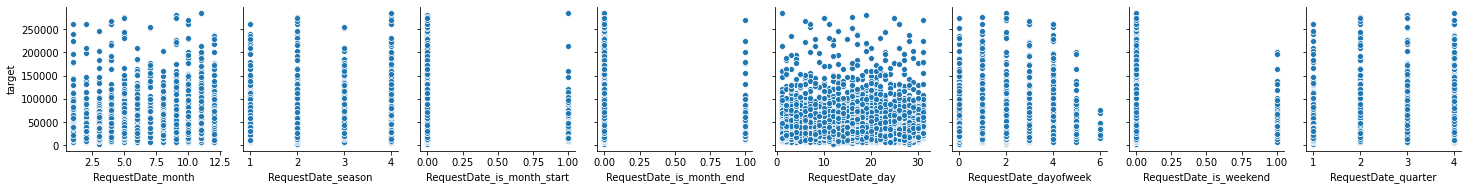

In [94]:
sns.pairplot(df, y_vars='target', x_vars=features_time);

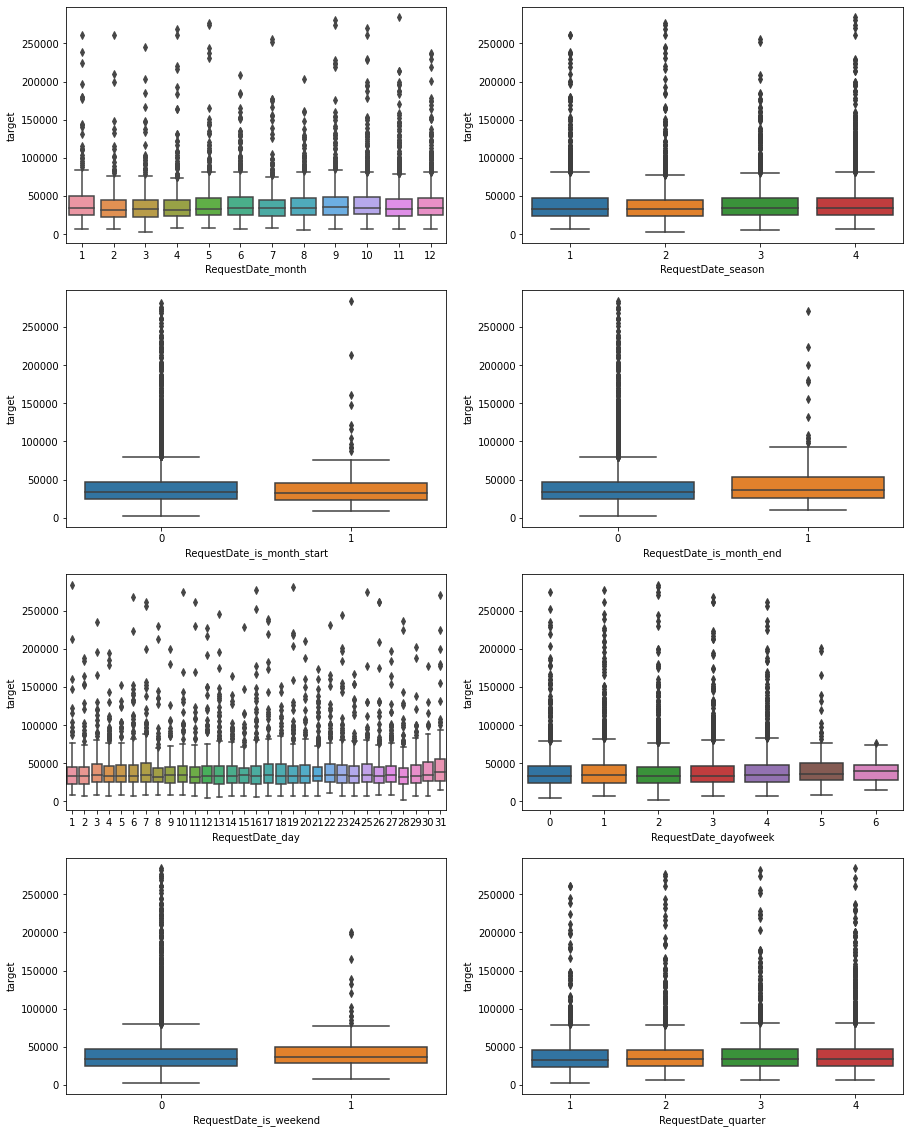

In [109]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

for ax, f in zip(axes.ravel(), features_time):
  sns.boxplot(x=f, y='target', data=df, ax=ax)

Четких зависимостей нет, но в начале, в конце месяца и в выходные люди с большим доходом кредит практически не запращивают

## Категориальные признаки

In [126]:
df[features_cat] = df[features_cat].astype('category')

In [127]:
len(features_cat)

18

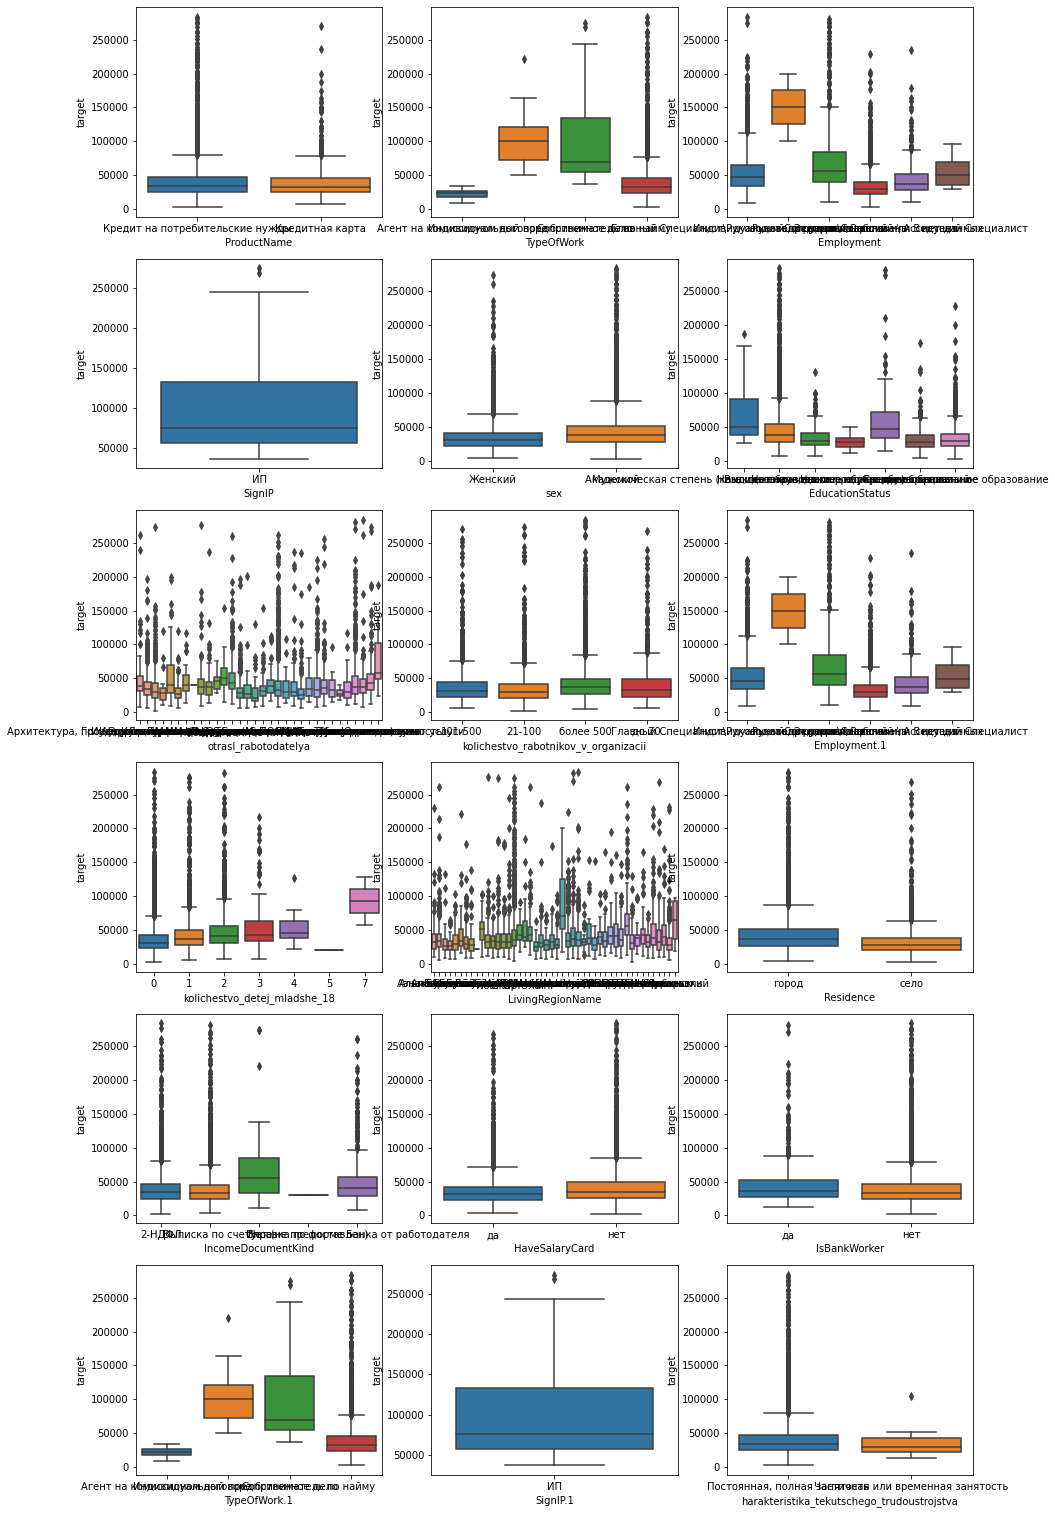

In [131]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,4.5*6))

for ax, f in zip(axes.ravel(), features_cat):
  sns.boxplot(x=f, y='target', data=df, ax=ax)

In [134]:
df[['SignIP', 'SignIP.1']].nunique()

SignIP      1
SignIP.1    1
dtype: int64

In [142]:
df[df['SignIP'] != df['SignIP.1']]

Empty DataFrame
Columns: [ProductName, CreditSum, TypeOfWork, Employment, SignIP, sex, age, EducationStatus, otrasl_rabotodatelya, kolichestvo_rabotnikov_v_organizacii, Employment.1, OrgStanding_N, kolichestvo_detej_mladshe_18, LivingRegionName, Residence, IncomeDocumentKind, HaveSalaryCard, IsBankWorker, TypeOfWork.1, SignIP.1, harakteristika_tekutschego_trudoustrojstva, target, RequestDate_month, RequestDate_season, RequestDate_is_month_start, RequestDate_is_month_end, RequestDate_day, RequestDate_dayofweek, RequestDate_is_weekend, RequestDate_quarter]
Index: []

In [300]:
df.drop('SignIP.1', axis=1, inplace=True)

In [145]:
df[['Employment', 'Employment.1']].nunique()

Employment      6
Employment.1    6
dtype: int64

In [155]:
temp = df[['Employment', 'Employment.1']].astype('object').fillna(-99)
temp[~(temp['Employment'] == temp['Employment.1'])]

ProductName  ...  RequestDate_quarter
3075  Кредит на потребительские нужды  ...                    4
7022                  Кредитная карта  ...                    4
8380  Кредит на потребительские нужды  ...                    2

[3 rows x 29 columns]

In [301]:
df.drop('Employment.1', axis=1, inplace=True)

In [159]:
df[['TypeOfWork', 'TypeOfWork.1']].nunique()

TypeOfWork      4
TypeOfWork.1    4
dtype: int64

In [303]:
f = 'TypeOfWork'
temp = df[[f, f+'.1']].astype('object').fillna(-99)
temp[~(temp[f] == temp[f+'.1'])]

Empty DataFrame
Columns: [TypeOfWork, TypeOfWork.1]
Index: []

In [304]:
df.drop(f+'.1', axis=1, inplace=True)

**!!!! Одинаковые признаки**

In [305]:
for f in ['SignIP.1', 'Employment.1', 'TypeOfWork.1']:
  features_cat.remove(f)

In [306]:
len(features_cat)

15

# Numerical

In [165]:
features_num

['CreditSum', 'age', 'OrgStanding_N', 'target']

In [168]:
df.age.min()

20

In [307]:
df['age_cat'] = pd.cut(df.age, bins=(0, 23, 30, 40, 50, 65, 100))
features_cat.append('age_cat')
features_num.remove('age')

In [183]:
df[df.CreditSum ==0]

ProductName  CreditSum  ...   age_cat CreditSum_log
398   Кредитная карта        0.0  ...  (40, 50]           0.0
418   Кредитная карта        0.0  ...  (40, 50]           0.0
421   Кредитная карта        0.0  ...  (30, 40]           0.0
429   Кредитная карта        0.0  ...  (30, 40]           0.0
475   Кредитная карта        0.0  ...  (23, 30]           0.0
...               ...        ...  ...       ...           ...
8290  Кредитная карта        0.0  ...  (40, 50]           0.0
8360  Кредитная карта        0.0  ...  (23, 30]           0.0
8405  Кредитная карта        0.0  ...  (50, 65]           0.0
8427  Кредитная карта        0.0  ...  (23, 30]           0.0
8454  Кредитная карта        0.0  ...  (23, 30]           0.0

[164 rows x 29 columns]

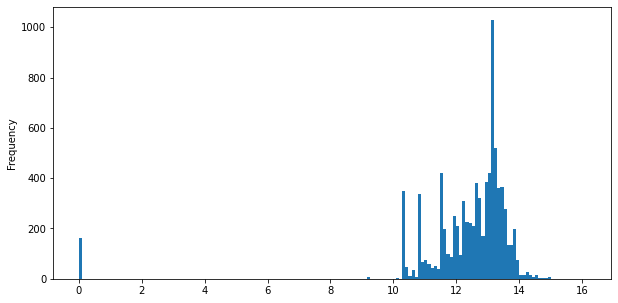

In [308]:
df['CreditSum_log'] = np.log1p(df.CreditSum)
df.CreditSum_log.plot(kind='hist', bins=160);

In [309]:
df.CreditSum.isna().sum()

5

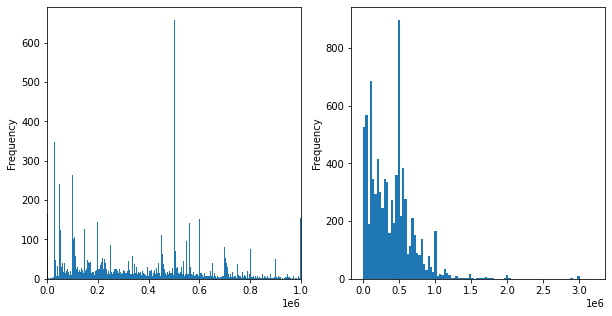

In [310]:
temp = df.CreditSum.copy()
temp = temp[temp <= 0.45*10**7]
# temp.shape, df.shape

plt.subplot(121)
temp.plot(kind='hist', bins=1000, xlim=(0,10**6))

plt.subplot(122)
temp.plot(kind='hist', bins=100);

In [311]:
temp[temp > 2.25*10**6].sort_values()

6546    2300000.0
6314    2367500.0
2817    2515200.0
7829    2609520.0
6572    2700000.0
2143    2900000.0
4946    2900000.0
2048    3000000.0
2447    3000000.0
2458    3000000.0
7100    3000000.0
7151    3000000.0
7193    3000000.0
7633    3000000.0
8124    3000000.0
5539    3200000.0
Name: CreditSum, dtype: float64

Логично, что люди берт в основном круглые суммы - 100 тыс, 200, 400 итд. Сделать категориальную фичу? Потому что лог пробразование не поможет примести распределение к нормальному.  Если да, то как сделать разбиение? по 100 тыс? или до 500 тыс разбиение по 50 тыс, а дальше по 100, а больше 1 млн еще реже?

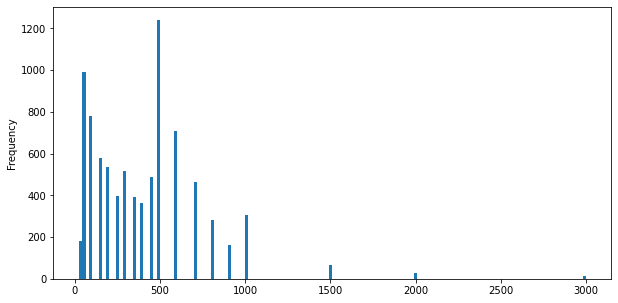

In [255]:
bins = [-1, 25,75,125,175,225,275,325,375,425,475,550,650,750,850,950,1250,1750,2500,3500]
labels = [25,50,100,150,200,250,300,350,400,450,500,600,700,800,900,1000,1500,2000,3000]
credit = pd.cut(temp/10**3, bins=bins, labels=labels).astype('int')
credit.plot(kind='hist', bins=150);
# pd.Series(np.log(credit)).plot(kind='hist', bins=100)

Распределение нормальным не стало, но теперь с данными можно работать как с категориальными

In [257]:
credit.nunique()

19

In [190]:
df[df['target']<7000].harakteristika_tekutschego_trudoustrojstva.value_counts()

Постоянная, полная занятость         13
Частичная или временная занятость     0
Name: harakteristika_tekutschego_trudoustrojstva, dtype: int64

In [193]:
df[df['target']<7000].CreditSum/1000

2131     300.00000
3347     140.54100
3374     100.00000
4065     400.00000
4615     150.00000
4715      60.00000
4832     158.56300
5576     183.26300
6966      30.83300
7264     600.00000
7619     100.00000
7859      40.93900
8280    1294.37132
Name: CreditSum, dtype: float64

Доход меньше мрот при этом полная занятость - как такое возможно? + запрашиваемый кредит на большие суммы больше 100 тыс, а то и миллион

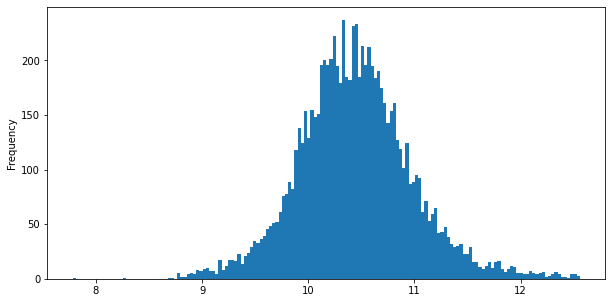

In [312]:
df['target_log'] = np.log1p(df.target)
df.target_log.plot(kind='hist', bins=160);

In [195]:
import scipy.stats as ss

In [196]:
ss.shapiro(df.target_log) # normal

(0.9888417720794678, 2.525738361519769e-25)

## Nan

In [313]:
features_na = df.columns[df.isna().sum()!=0]
features_na

Index(['CreditSum', 'TypeOfWork', 'Employment', 'SignIP',
       'otrasl_rabotodatelya', 'kolichestvo_rabotnikov_v_organizacii',
       'Residence', 'IncomeDocumentKind',
       'harakteristika_tekutschego_trudoustrojstva', 'CreditSum_log'],
      dtype='object')

In [314]:
df[features_na].nunique().sort_values()

SignIP                                           1
Residence                                        2
harakteristika_tekutschego_trudoustrojstva       2
TypeOfWork                                       4
kolichestvo_rabotnikov_v_organizacii             4
IncomeDocumentKind                               5
Employment                                       6
otrasl_rabotodatelya                            32
CreditSum                                     2853
CreditSum_log                                 2853
dtype: int64

In [277]:
for f in [feat for feat in features_na if feat in features_cat]:
  display(f, df[f].value_counts(), df[f].isna().sum())
  print('----------')

'TypeOfWork'

по найму                          4804
Собственное дело                    44
Индивидуальный предприниматель      15
Агент на комиссионом договоре        4
Name: TypeOfWork, dtype: int64

3634

----------


'Employment'

Сотрудник \ Рабочий \ Ассистент                   5985
Главный Специалист\Руководитель среднего звена    1298
Эксперт\Старший или Ведущий Специалист             672
Руководитель высшего звена                         537
нет данных                                           4
Индивидуальный предприниматель                       2
Name: Employment, dtype: int64

3

----------


'SignIP'

0     8442
ИП      59
Name: SignIP, dtype: int64

0

----------


'otrasl_rabotodatelya'

Прочее                                           2015
Образование                                       843
Финансовые институты                              809
Государственная служба                            675
Здравоохранение                                   622
Торговля и бытовые услуги населению               508
Нефть, нефтепереработка, газ                      494
Транспорт                                         368
Машиностроение                                    295
Химическая промышленность                         234
Архитектура, проектирование и конструирование     212
Сельское хозяйство                                210
Электроэнергетика                                 192
Пищевая промышленность                            187
Правоохр.органы (МинОбороны, МинЮстиции)          111
Культура и искусство                              111
Связь и телекоммуникации                          110
Металлургия                                       109
Информационные технологии   

1

----------


'kolichestvo_rabotnikov_v_organizacii'

более 500    3917
21-100       2100
101-500      1683
до 20         800
Name: kolichestvo_rabotnikov_v_organizacii, dtype: int64

1

----------


'Residence'

город    5504
село     2339
Name: Residence, dtype: int64

658

----------


'IncomeDocumentKind'

2-НДФЛ                                    4277
Выписка по счету                          3472
Справка по форме Банка от работодателя     614
Иное                                        35
Нет (не предоставлен)                        1
Name: IncomeDocumentKind, dtype: int64

102

----------


'harakteristika_tekutschego_trudoustrojstva'

Постоянная, полная занятость         8300
Частичная или временная занятость      15
Name: harakteristika_tekutschego_trudoustrojstva, dtype: int64

186

----------


In [317]:
df[df.TypeOfWork == 'Индивидуальный предприниматель'].Employment.isna().sum()

2

Employment - всего 3 пропущенных значения. 
Причем есть катеогри ИП, которая так же присутсвуте в признаке TypeOfWork. Можно заполнить 2 пропуска в Employment  основываясь на TypeOfWork, а оследнему пропуску присвоить категорию - нет данных

In [326]:
idx = (df['Employment'].isna()) & (df.TypeOfWork == 'Индивидуальный предприниматель')
df.loc[idx, 'Employment'] = df[idx].TypeOfWork
df.Employment.fillna('нет данных', inplace=True)

In [330]:
df.Employment.value_counts()

Сотрудник \ Рабочий \ Ассистент                   5985
Главный Специалист\Руководитель среднего звена    1298
Эксперт\Старший или Ведущий Специалист             672
Руководитель высшего звена                         537
нет данных                                           5
Индивидуальный предприниматель                       4
Name: Employment, dtype: int64

In [331]:
df[df.TypeOfWork == 'Индивидуальный предприниматель'].Employment.value_counts()

Руководитель высшего звена                        7
Главный Специалист\Руководитель среднего звена    3
Индивидуальный предприниматель                    3
Сотрудник \ Рабочий \ Ассистент                   1
нет данных                                        1
Name: Employment, dtype: int64

**значений ИР в Employment всего 4, можно удалить категорию заменив ее значения на те, которые соответвуют ИП из TypeOfWork, т.е на Руководитель высшего звена**

In [328]:
df.SignIP = df.SignIP.astype('object').fillna(0).astype('category')

In [340]:
df = df[(df.otrasl_rabotodatelya.notna())&(df.kolichestvo_rabotnikov_v_organizacii.notna())]

In [345]:
df.TypeOfWork = df.TypeOfWork.astype('object').fillna('na').astype('category')

In [347]:
df.IncomeDocumentKind.fillna('Нет (не предоставлен)', inplace=True)

In [348]:
df.Residence = df.Residence.astype('object').fillna('na').astype('category')

In [349]:
df.harakteristika_tekutschego_trudoustrojstva = df.harakteristika_tekutschego_trudoustrojstva.astype('object').fillna('na').astype('category')

In [351]:
df.CreditSum.fillna(0, inplace=True)
df.CreditSum_log.fillna(0, inplace=True)

SignIP vs TypeOfWork

In [281]:
df[df.SignIP == 'ИП'].TypeOfWork.value_counts()

Собственное дело                  44
Индивидуальный предприниматель    15
по найму                           0
Агент на комиссионом договоре      0
Name: TypeOfWork, dtype: int64

In [282]:
df[df.TypeOfWork == 'Индивидуальный предприниматель'].SignIP.value_counts()

ИП    15
Name: SignIP, dtype: int64

# Model

In [422]:
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [362]:
features_num.remove('target')

In [356]:
target = df.target
target_log = df.target_log

In [405]:
for f in features_cat:
  df[f] = df[f].astype('category').cat.codes

In [407]:
to_drop = ['age', 'CreditSum_log', 'target','target_log']

In [409]:
X, X_test, y, y_test = train_test_split(df.drop(to_drop, axis=1), target)

cv5 = ShuffleSplit(5, random_state=2020)

In [410]:
scaler = StandardScaler()

X_scaler, X_test_scaler = X.copy(), X_test.copy()
X_scaler[features_num] = scaler.fit_transform(X[features_num])
X_test_scaler[features_num] = scaler.transform(X_test[features_num])

In [411]:
scaler_y = StandardScaler()

y_scaler, y_test_scaler = y.copy(), y_test.copy()
y_scaler = scaler_y.fit_transform(y.to_frame()).reshape(-1,)
y_test_scaler = scaler_y.transform(y_test.to_frame()).reshape(-1,)

In [456]:
def get_train_val(X, y, cv5):
  for train_idx, val_idx in cv5.split(X, y):
      X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
      X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
      break
  return X_train, y_train, X_val, y_val 

In [458]:
X_train,y_train,X_val,y_val = get_train_val(X_scaler, pd.Series(y_scaler), cv5)

In [449]:
lr = Ridge(alpha=1e-3)
cv = cross_validate(lr, X_scaler,y_scaler, scoring='neg_mean_squared_error', cv=cv5, n_jobs=-1, return_train_score=True)

In [451]:
cv['test_score'].mean()

-0.7338073986322171

In [459]:
lr.fit(X_train, y_train)
pred = lr.predict(X_val)
mean_squared_error(y_val, pred)

0.7483449015128049

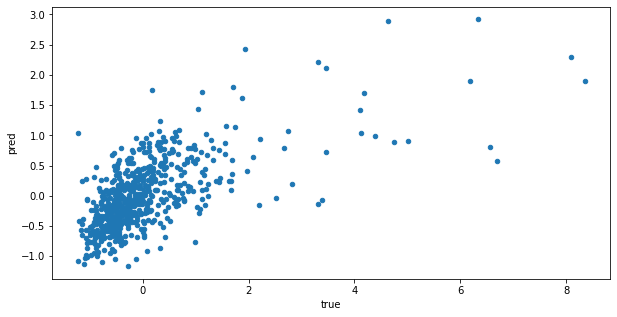

In [460]:
pd.DataFrame(np.vstack([y_val.values,pred]).T, columns=['true', 'pred']).plot(x='true', y='pred', kind='scatter');

In [461]:
t1 = scaler_y.inverse_transform(y_val)
t2 = scaler_y.inverse_transform(pred)

mean_squared_error(t1, t2)

558302346.4634647